## ACSU Deep Learning and Vision Reading Group: HW 1

Welcome! In this homework we will be implementing a simple PyTorch CNN classifier trained on the CIFAR-10 dataset. There will be a PyTorch tutorial section, where we will implement the classifier and train on CIFAR-10, and also a homework section where we will take a look at how we can improve generalization performance with some regularization techniques. 

### Part 0: Brief Setup

Let's get some dependencies out of the way. I assume you have already installed Python 3 (or 2) with numpy. What you will additionally need is `pytorch` along with it's companion `torchvision`. For greatest accessibility, we will be using the CPU-only versions of PyTorch. If you want the GPU acceleration enabled PyTorch bindings, please run the commands here (http://pytorch.org/) according to your CUDA configuration. For CPU-only PyTorch, run the following for Python 3:

In [42]:
!pip install http://download.pytorch.org/whl/cpu/torch-0.3.1-cp36-cp36m-linux_x86_64.whl 
!pip install torchvision

    100% |████████████████████████████████| 47.0MB 6.3MB/s ta 0:00:012
  Found existing installation: torch 0.3.1.post2
    Uninstalling torch-0.3.1.post2:
      Successfully uninstalled torch-0.3.1.post2


Or the following for Python 2:

In [43]:
!pip install http://download.pytorch.org/whl/cpu/torch-0.3.1-cp27-cp27mu-linux_x86_64.whl 
!pip install torchvision 

torch-0.3.1-cp27-cp27mu-linux_x86_64.whl is not a supported wheel on this platform.


And you will be all set. Onward to the tutorial!

### Part 1: Pytorch Tutorial - Learning to Classify CIFAR-10

To begin, let's load pytorch (`import torch`) along with `torchvision` so we can load our dataset. Torchvision is an additional companion package to `torch` that contains useful vision-specific add-ons (for example ResNet50 and Inception-V3 models pretrained on ImageNet). We also want `%matplotlib inline` for future visualizations :).

In [97]:
import torch
import torchvision
import torchvision.transforms as transforms
%matplotlib inline

Note that images from the CIFAR-10 dataset have dimensions `3x32x32` (they are 3 channel RGB images, with 32x32 spatial resolution). There are 50,000 training images and 10,000 test images. Initially, all of the images intensity values are in the range `0..255`. By convention we first normalize this to `0..1` with the following `transforms.ToTensor()` transform. This also converts the images from `PIL` images to torch `Tensor`s, which we will use for fast training (`Tensor`s are abstractions for our data that torch introduces so that it can automatically accelerate computations whenever we use them (e.g. matrix multiplication with tensors)). We further mean normalize each channel by `0.5` and divide by the standard deviation, which is in this case approximated to be `0.5`. The idea is that we normalize our images to be in the range `-1..1`. The transforms can be summarized as doing the following: 

First `(0..255) / 255 = (0..1)` <br/>
then `(0..1) - 0.5 = (-0.5..0.5)` <br/>
then `(-0.5..0.5) / 0.5 = (-1..1)`.

We do this across all 3 channels of the images, hence the 3-tuples in the `transforms.Normalize` code:

In [98]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

`transforms.Compose` will simply apply our transforms in succession to the dataset when we load it in the following way (note that we have specified the above transform with `transform=transform`):

In [99]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


The above code will download the CIFAR-10 dataset to the path specified by `root`. Note that we also have separate concepts of a `dataset` and a `DataLoader`. The dataset is in this case just an abstraction for our data, but when we create a DataLoader we specify a mechanism that will be used to load the data during training. As we cannot afford to load and train on all of it at once, we typically load small batches at a time (`batch_size=4`). It is also considered good practice to shuffle (`shuffle=True`) the data during each epoch (i.e. during each run through all of the data).

Following are the classes of CIFAR-10:

In [100]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let's visualize some images (we can just query our DataLoader for a batch of images, and then we also need to denormalize back to `0..255` for display purposes): 

 ship   car  frog truck


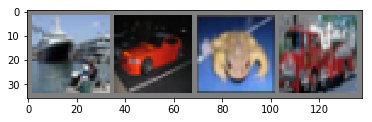

In [101]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = iter(trainloader).next() # get some images
images = torchvision.utils.make_grid(images) # sow our batch of images (4x3x32x32) into a grid (3x32x128)
images = images / 2 + 0.5 # denormalize
images = images.numpy() # go from Tensor to numpy array
# switch channel order back from torch Tensor to PIL image: going from 3x32x32 - to 32x32x3
images = np.transpose(images, (1, 2, 0)) 
plt.imshow(images) # display

print(' '.join('%5s' % classes[labels[j]] for j in range(4))) # print labels too

Okay. Now that we're a bit more familiar with the data, let's go ahead and define the network we will train to classify our images. First, we'll need some imports. `torch.nn` is the neural network torch module that will let us use a lot of useful layers in our network. `torch.nn.functional` provides some useful functions, like activations (e.g. `ReLU`):

In [102]:
import torch.nn as nn
import torch.nn.functional as F

We will now define our network. Note that it will inherit from `nn.Module` (as this is the abstraction torch uses for backpropagation), which means we will be required to specify layers/modules are are using in `__init__` and also specify what our network will do when we forward pass the data in `forward`: 

In [103]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # note that the three parameters for a conv layer we specify are input_channels,
        # output_channels, and kernel_size. In the first conv layer, we are taking 3 input channels (RGB),
        # and convlve with a 5x5 kernel to produce a single output channel. The values of the 5x5 kernel
        # are the learned parameters in this case, and the 5x5 kernel will become our the 'learned feature'
        # after training. We do this for, in this case, 6 different 5x5 kernels to produce 6 output channels.
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        # max pooling here will just stride a 2x2 window through our entire images and take the highest
        # activation value in each window, thereby reducing each dimension by a factor of 2
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # the linear, or fully connected layer, will take the flattened 16 5x5 output channels of our conv layer,
        # and connect them fully to 120 hidden units
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        
        # now we just connect the 120 units to another 84 hidden units in the next layer, similar to what we
        # do in regular multi-layer perceptrons
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # x is the input. A noticeable pattern is that we will convolve, then pass through activations,
        # and then pool. This happens dozens of times in larger networks.
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # now we flatten the outputs and pass them to the first linear layer. Recall that the purpose
        # of linear layers is to give us global context for all of our local conv features.
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Now let's go ahead and initialize our network, define a loss function, and define an optimizer:

In [158]:
import torch.optim as optim

net = Net() # just initializing an instance of what we built above
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

I will explain a bit more clearly what specifically the optimizer does in the training code, but know that the `CrossEntropyLoss` is a way of quantifying how closely our network predicts the actual labels of images. If it is `0`, our network predicts the labels perfectly. If it is a very high number, our network is doing a very poor job of classifying the data. 

We are now ready to get into the training code. I will provide explanationsin the comments as we go:

In [159]:
# something we'll need for training (explained below)
from torch.autograd import Variable

# a nice helper function for storing running averages
class AverageMeter(object):
    #Computes and stores the average and current value
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# TRAINING STARTS
# epoch specifies what pass we are on through the dataset - typically we want to do multiple passes
for epoch in range(2):
    loss_meter = AverageMeter()
    
    # note the 0, as we want to start form the 0th batch
    for i, data in enumerate(trainloader, 0):
        # get inputs
        inputs, labels = data
        
        # we now wrap the data Tensors in Variables. Variables are an abstraction around Tensors
        # that torch creates so that it can attach relevant gradient information to parameters
        # in the network. As our inputs variables are forwarded, all of the other parameters will become
        # variables as well because of this initial wrapping. When a tensor t is wrapped as a Variable v,
        # we can still access the previous tensor with v.data, and when the gradient is computed with respect
        # to that tensor it will be stored in t.grad.data (grad is itself a variable)
        inputs, labels = Variable(inputs), Variable(labels)
        
        # remember how we specified net.parameters() to our optimizer before? This let our optimizer know
        # about all trainable parameters in our network. Here it goes through all the trainable, Variable
        # wrapped parameters, and zeros their gradients by doing v.grad.data = 0. This is because in pytorch
        # gradients are accumulated in the `grad.data`s of your parameters after each iteration, so we want
        # to zero them out each time so that we don't accidentally use some old gradients twice
        optimizer.zero_grad()
        
        # first forward pass the batch through our network
        outputs = net(inputs)
        
        # now compute the loss
        loss = criterion(outputs, labels)
        
        # now, what we want to do is lower the loss. To do that, we will need to step in the direction
        # of the negative gradient. loss.backward() computes the gradients of our loss with respect to
        # each parameter, and actually populates v.grad.data for all trainable parameters
        loss.backward()
        
        # the optimizer will then actually update the parameter values using the gradient. It will do roughly
        # v.data -= learning_rate * v.grad.data . The learning rate (lr0.001) we defined above for our optimizer
        # will control the size of the step we take in our gradient direction, and the momentum
        # (momentum=0.9) will control how much of the previous gradient we want to retain in the current step,
        # and how much of the new gradient we will add (0.9 means to keep most of the old gradient). The
        # optimizer we are using (SGD) is a relatively simple one, and stands for Stochastic Gradient Descent.
        # optim.Adam and optim.RMSProp are some more advanced optimizers you might want to try using later.
        optimizer.step()
        
        # now let's just update the loss, and print some stats if needed, and we're ready for the next batch
        loss_meter.update(loss.data[0])
        
        if i % 2000 == 0: # print the loss every 2000 batches
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, loss_meter.val))
            loss_meter.reset()

print('Done!')

[1,     1] loss: 2.300
[1,  2001] loss: 1.953
[1,  4001] loss: 1.766
[1,  6001] loss: 1.512
[1,  8001] loss: 1.580
[1, 10001] loss: 0.864
[1, 12001] loss: 1.653
[2,     1] loss: 0.834
[2,  2001] loss: 0.997
[2,  4001] loss: 1.671
[2,  6001] loss: 1.243
[2,  8001] loss: 1.481
[2, 10001] loss: 0.890
[2, 12001] loss: 1.337
Done!


Alright, let's quickly sample a few test images and see if our network can correctly predict them. First we load the data like we did previously:

Correct labels:    dog plane  ship horse


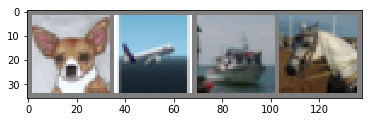

In [185]:
images, labels = iter(testloader).next() # get some images
images_copy = images.clone()
images = torchvision.utils.make_grid(images) # sow our batch of images (4x3x32x32) into a grid (3x32x128)
images = images / 2 + 0.5 # denormalize
images = images.numpy() # go from Tensor to numpy array
# switch channel order back from torch Tensor to PIL image: going from 3x32x32 - to 32x32x3
images = np.transpose(images, (1, 2, 0)) 
plt.imshow(images) # display

print('Correct labels: ', ' '.join('%5s' % classes[labels[j]] for j in range(4))) # print labels too

Now, let's forward these through our trained network and see what our predicted labels are:

In [186]:
outputs = net(Variable(images_copy))

For each image, we will have an output that is in fact a vector of 10 values. Each value corresponds to the likelihood our network assigns to the image being that particular class. For example, let us take a look at the distribution of these likelihoods for the first image by running the following code:

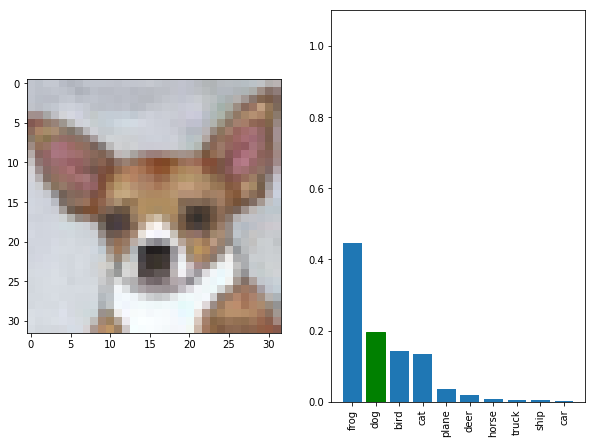

In [187]:
img = images_copy.numpy()[0]
img = np.transpose((img / 2 + 0.5), (1, 2, 0))
correct_class = labels[0]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
fig.sca(ax1)
p = outputs.data[0].numpy()
p = np.exp(p - np.max(p))
p = p / p.sum(axis=0)
ax1.imshow(img)
fig.sca(ax1)
topk = list(p.argsort()[-10:][::-1])
topprobs = p[topk]
barlist = ax2.bar(range(10), topprobs)
if correct_class in topk:
    barlist[topk.index(correct_class)].set_color('g')
plt.sca(ax2)
plt.ylim([0, 1.1])
plt.xticks(range(10),
           [classes[i][:15] for i in topk],
           rotation='vertical')
fig.subplots_adjust(bottom=0.2)
plt.show()

The green bar indicates the likelihood for the correct class - notice that it is not necessarily the highest, because the classifier still makes errors. We will take the index with the highest value as the predicted class of our network, and use the `classes` array we previously defined to recover the actual class label:

In [108]:
# torch.max returns both the max and the argmax - we only care about the argmax, since that indicates
# what indices have the greatest likelihood value
_, predicted = torch.max(outputs.data, 1)

# now we look up the highest likelihood indices and print their classes
print('Predicted labels: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted labels:    dog   dog   car  frog


Not bad I guess. Let's compute how we did over the entire test set:

In [109]:
correct = 0
total = 0
for i, data in enumerate(testloader, 0):
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('Accuracy on all 10000 test images: %d %%' % (100 * correct/total))

Accuracy on all 10000 test images: 56 %


For 2 epochs of training, that doesn't look too bad. Recall that random guessing on this 10 class dataset would produce an accuracy of 10%, but we are substantially above that. Let's also take a quick look at per class accuracy:

In [47]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for i, data in enumerate(testloader, 0): 
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        class_correct[labels[i]] += c[i]
        class_total[labels[i]] += 1
        
for i in range(10):
    print('Accuracy of %5s: %2d %% ' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 64 % 
Accuracy of   car: 80 % 
Accuracy of  bird: 33 % 
Accuracy of   cat: 23 % 
Accuracy of  deer: 68 % 
Accuracy of   dog: 33 % 
Accuracy of  frog: 61 % 
Accuracy of horse: 70 % 
Accuracy of  ship: 73 % 
Accuracy of truck: 46 % 


Looks like we can do pretty well with cars, but if you are a cat-lover you likely won't be happy with our 1 out of 5 chance of classifying your cat incorrectly :( . Let's see if we can still run for the same number of epochs (2) but improve our performance by using some regularization techniques. Onward to the regularization homework portion of these notes!

### Part 2: Improving our Classifier with Regularization

As you may recall from lecture, two very popular regularization techniques are BatchNorm and Dropout. The issue with our former network is that typically, if we let it run too long, it will begin to overfit to our training data, and fail to generalize to the test data (accuracy on test data will start to decrease!). This problem happens because often, deep learning models have so many parameters that they can learn to memorize the specific training data that we give them with more training time, as opposed to learning traits of that data that will help them generalize to test data. We will take a look at how BatchNorm and Dropout help us avoid overfitting and reach higher accuracies with more epochs by limiting the expressive power of deep neural networks in the following experiments. Since we'll be evaluating a lot in this section on different networks, let's make a function for our previous testing code and let it evaluate an arbitrary network that we specify:

In [202]:
def test(network):
    correct = 0
    total = 0
    for i, data in enumerate(testloader, 0):
        images, labels = data
        outputs = network(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy on all 10000 test images: %d %%' % (100 * correct/total))

Let's also define a train function that will take in and train with a specified network and evaluate at the end of each epoch:

In [203]:
def train(network, n_epochs=2):
    for epoch in range(n_epochs):
        loss_meter = AverageMeter()

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)
            optimizer.zero_grad()
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_meter.update(loss.data[0])
            if i % 2000 == 0: # print the loss every 2000 batches
                print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, loss_meter.val))
                loss_meter.reset()
        print('Testing epoch', (epoch+1))
        test(network)
    print('Done!')

(a) First, let's go ahead and try out Dropout. Given that in pytorch we use a Dropout layer for convolutions, specified as `nn.Dropout(p=0.5)`, where you set `p` to the probability that any given node is zeroes out during a forward pass, add dropout after the convolutional layers in our network. Similarly, we can add Dropout after linear layers with `nn.Dropout(p=0.5)`, however do not do so below to avoid over-regularization (see note on over-regularization at the end):

In [204]:
class DropoutNet(nn.Module):
    def __init__(self):
        super(DropoutNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        # start: add a batchnorm layer here:
        self.dr1 = nn.Dropout(p=0.5)
        # end
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # start: add a batchnorm layer here:
        self.dr2 = nn.Dropout(p=0.5)
        # end
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # DO NOT add a batch norm layer here (in general, ever). We do not mess with the outputs
        # as they will be directly compared to the ground truth labels in the loss function.
    
    def forward(self, x):
        # start: change this code to use your Dropout layers
        x = self.pool(F.relu(self.dr1(self.conv1(x))))
        x = self.pool(F.relu(self.dr2(self.conv2(x))))
        # end
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Here's an important note. Now that you have added Dropout to your network, we need to make a distinction between the train and test modes of your network. During training, the Dropout layers will automatically zero out any given node with specified probability `p`. During testing, we do not want this to happen, as we just want to evaluate and use all information from the network. Conveniently, PyTorch provides us with `net.train()` and `net.eval()` (for testing) so that we can automatically turn on or off whether or not we want nodes to be stochastically zeroed out. We will see in a bit that we also need `net.train()` and `net.eval()` for BatchNorm. For the time being, let's go ahead and train your DropoutNet for 2 epochs:

In [205]:
net = DropoutNet()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # set our optimizer to optimize our new net
net.train() # we enable dropout during training
train(net, 2) # train the network for 2 epochs

[1,     1] loss: 2.284
[1,  2001] loss: 1.741
[1,  4001] loss: 1.959
[1,  6001] loss: 1.695
[1,  8001] loss: 1.579
[1, 10001] loss: 1.658
[1, 12001] loss: 1.548
Testing epoch 1
Accuracy on all 10000 test images: 45 %
[2,     1] loss: 0.985
[2,  2001] loss: 1.496
[2,  4001] loss: 0.947
[2,  6001] loss: 1.370
[2,  8001] loss: 1.708
[2, 10001] loss: 1.692
[2, 12001] loss: 0.738
Testing epoch 2
Accuracy on all 10000 test images: 52 %
Done!


Not great, as a result of being limited by CPU resources (only running for 2 epochs) :(. If you have the time, run both the original network and the DropoutNet for a larger number of epochs, say 10 or 20, and note that although the DropoutNet takes longer to train/reach the same accuracy, it does in fact eventually reach a higher accuracy than the original.

(b) Now, let's go ahead and try out BatchNorm. Given that in PyTorch we use a BatchNorm2d layer for convolutions, specified as `nn.BatchNorm2d(n)`, where `n` is the number of output channels in the convolution, add BatchNorm for convolution layers to the previous network. Similarly, for linear layers, we would use `nn.BatchNorm1d(n)`, where n is the number of output units of the linear layer. However, please only add BatchNorm for the convolutional layers, because we do not want to **over-regularize** (see note at the end about over-regularization). Please add the BatchNorm **after** the ReLU activation (even though the original BatchNorm paper suggests putting it before, empirically it has been shown to work better when placed after the activation):

In [206]:
class BatchNormNet(nn.Module):
    def __init__(self):
        super(BatchNormNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        # start: add a batchnorm layer here:
        self.bn1 = nn.BatchNorm2d(6)
        # end
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # start: add a batchnorm layer here:
        self.bn2 = nn.BatchNorm2d(16)
        # end
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # start: add a batchnorm layer here (don't use it later on though):
        self.bn3 = nn.BatchNorm1d(120)
        # end
        self.fc2 = nn.Linear(120, 84)
        # start: add a batchnorm layer here (don't use it later on though):
        self.bn4 = nn.BatchNorm1d(84)
        # end
        self.fc3 = nn.Linear(84, 10)
        # DO NOT add a batch norm layer here. We do not mess with the outputs
        # as they will be directly compared to the ground truth labels in the loss function.
    
    def forward(self, x):
        # start: change this code to use your conv Batchnorm layers
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        # end
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

An important note. Now that you have added BatchNorm to your network, we need to make a distinction between the train and test modes of your network. During training, the BatchNorm layers will automatically update their parameters (mean and variance) upon each forward pass. During testing, we do not want this to happen, as we just want to evaluate. Conveniently, the PyTorch functions `net.train()` and `net.eval()` (for testing) also automatically turn on or off whether or not BatchNorm parameters are being updated upon each forward pass. For the time being, let's go ahead and train your BatchNormNet for 2 epochs:

In [ ]:
net = BatchNormNet()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # set our optimizer to optimize our new net
net.train() # we let the BatchNorm parameters update during forward passes
train(net, 2) # train the network for 2 epochs

[1,     1] loss: 2.328
[1,  2001] loss: 2.326
[1,  4001] loss: 0.803
[1,  6001] loss: 1.573
[1,  8001] loss: 1.406
[1, 10001] loss: 1.000
[1, 12001] loss: 1.767
Testing epoch 1
Accuracy on all 10000 test images: 52 %
[2,     1] loss: 0.974
[2,  2001] loss: 1.649
[2,  4001] loss: 1.004
[2,  6001] loss: 1.214
[2,  8001] loss: 1.192
[2, 10001] loss: 0.234
[2, 12001] loss: 1.359
Testing epoch 2


Not bad - seems to even be better than the original network for only 2 epochs. If you have the chance to, run it for longer and see how good the results you can get are! Note that BatchNorm will also prevent you from overfitting after long training runs, similar to Dropout. Also feel free to tweak the hyperparameters for the convolutional and fully-connected layers. I want to also make a slight note about potential issues. 

**Over-regularlization**. Over-regularizing is possible, and happens when you regularize your network so much that it is unable to learn anything. It may help to decrease the number of dropout layers or batchnorm layers you use if you see that your network that was previously able to decrease in training loss now fails to do so (after adding regularization). Usually you detect over-regularization empirically when your training loss fails to decrease, whereas previously (before regularization) is was able to decrease with training time.

Hopefully we were able to demonstrate that even on our toy CIFAR-10 example, regulalarization in the form of BatchNorm (✓) and Dropout (eventually) helps quite significantly. Quick side note: most people nowadays just use BatchNorm (not Dropout) as it is usually sufficient to just add Batchnorm (instead of Batchnorm AND Dropout) for regularization purposes. Though you can certainly still use it practice if it gives you good empirical results. Anyways, I think we're done for now. I'll see you next class! -Isay

**References**. Parts of the tutorial section were modified from Adam Paszke's tutorial here: https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py and also Anish Athalye's blog post here: https://www.anishathalye.com/2017/07/25/synthesizing-adversarial-examples/ .